Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

submission deadline till 9pm friday

submission instruction:
create your github repo and keep all the assisgnments over there(in that github repo)
i will share one googleform in group after completing your assignment you can share the github link through that google form. 

In [1]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import BaseMessage
from typing import TypedDict,Annotated,Sequence
import operator
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature=0.2, max_output_tokens=1000)
output=model.invoke("what is capital of India")
output.content

'The capital of India is **New Delhi**.'

In [4]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="The topic of the conversation")
    Reasoning: str = Field(description="The reasoning behind the topic selection")
    

In [5]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "The topic of the conversation", "title": "Topic", "type": "string"}, "Reasoning": {"description": "The reasoning behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [7]:
def function_1(state:AgentState):
    question=state['messages'][-1]

    print("Question:", question)

    template="""
    You are an expert in topic selection. Your task is to classify the given user query into one of the following categories: [USA, 2025 or very recent or this year and USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt=PromptTemplate(template=template,
                          input_variables=["question"],
                          partial_variables={"format_instructions": parser.get_format_instructions()}) 
    
    chain = prompt | model | parser

    response=chain.invoke({"question": question})

    print("Parsed response:", response)

    return {"messages": [response.Topic]}



In [8]:
state={"messages":["what is today weather?"]}
#state={"messages":["what is a GDP of usa??"]}
function_1(state=state)

Question: what is today weather?
Parsed response: Topic='Not Related' Reasoning='The query is about the current weather, which is not related to the USA, 2025, or any specific year.'


{'messages': ['Not Related']}

In [9]:
def router(state: AgentState):
    print("->Router ->")

    last_message = state['messages'][-1]
    print('last_message:', last_message)

    if 'usa' in last_message.lower():
        if "2025" in last_message:
            return "Web Search Call"
        else:
            return "RAG Call"
    else:
        return "LLM Call"

In [10]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in new_docs]
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

c:\Users\srira\anaconda3\envs\agenticai_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [12]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import RunnableLambda

def function_4(state:AgentState):
    print("-> Web Crawler ->")
    # Search the web for the answer
    question = state["messages"][0]

    tavily_tool = TavilySearchResults()

    search_result = tavily_tool.run(question)
    input_data = {
            "search_result": search_result,
            "question": question
        }
    
    prompt = PromptTemplate.from_template(
        "Based on the following web search result, answer the user's question:\n\n"
        "Search Result:\n{search_result}\n\n"
        "Answer the question and summarize the top 5 results in form of a short summary: {question}"
    )
    search_result = tavily_tool.run(question)

    chain = (prompt | model | StrOutputParser())
    result = chain.invoke(input_data)

    return {"messages": [result]}

In [14]:
state={"messages":["what is the gdp of usa in 2025?"]}
function_3(state=state)

-> LLM Call ->


{'messages': ["We don't know the final GDP of the USA for 2025 yet.  Official figures will not be available until sometime in 2026.  Any number given now would be a projection or forecast, and those vary widely depending on the source and the assumptions made about economic growth, inflation, and other factors.  Therefore, I cannot provide a definitive answer."]}

In [ ]:
from typing import Optional
from langchain.chat_models import ChatOpenAI

def validate_output(llm_output: dict) -> str:
    print("-> Validation ->")
    """
    Validates the LLM output based on heuristics and optionally via another LLM-based critique.

    Args:
        llm_output (str): The output from the LLM pipeline.

    Returns:
        dict: Validation report with keys like 'is_valid', 'issues', 'score'.
    """
    use_llm_check: bool = True
    question=state["messages"][0]
    llm_output=llm_output.get("messages")[2]
    print('--------check point 1--------')
    issues = []
    score = 1.0  # Start with perfect score

    # --- Heuristic Checks ---
    if not llm_output.strip():
        issues.append("Output is empty.")
        score -= 0.5

    if len(llm_output.strip()) < 50:
        issues.append("Output is unusually short.")
        score -= 0.3

    if "I don't know" in llm_output or "I'm not sure" in llm_output:
        issues.append("Model expressed uncertainty.")
        score -= 0.3

    if llm_output.lower().count("http") < 1:
        issues.append("No source links found. Expected at least one.")
        score -= 0.2
    print('--------check point 2--------')
    # --- Optional LLM-based Meta-Evaluation ---
    if use_llm_check:
        llm = ChatOpenAI(model="gpt-4", temperature=0)
        critique_prompt = f"""
        Evaluate the following answer to see if it correctly and completely answers the question.

        Question: {question}

        Answer:
        {llm_output}

        Respond with YES or NO: Is the answer relevant and correct?
        Then explain briefly.
        """
        critique = llm.invoke(critique_prompt).content
        if "no" in critique.lower():
            issues.append("LLM critique flagged the output as possibly irrelevant or incorrect.")
            score -= 0.4
    print('--------check point 3--------')
    # Final decision
    is_valid = score >= 0.5
    if is_valid:
        print('--------check point 4--------')
        return llm_output
    else:
        print('--------check point 5--------')
        return "Supervisor"



In [45]:
def validation(st):
    print("-> final validation ->")

    if st == "Supervisor":
        return "Supervisor"
    else:
        return st

In [53]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("Web Crawler",function_4)
workflow.add_node("validate_output", validate_output)

workflow.set_entry_point("Supervisor")
workflow.set_finish_point("validate_output")
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Web Search Call": "Web Crawler",
    },
    "validate_output",
    validation
         
)

workflow.add_edge("RAG","validate_output")
workflow.add_edge("LLM","validate_output")
workflow.add_edge("Web Crawler","validate_output")
#workflow.add_edge("validate_output", END or "Supervisor")
app=workflow.compile()


TypeError: StateGraph.add_conditional_edges() takes from 3 to 5 positional arguments but 6 were given

In [50]:
state={"messages":["What is the present gdp of usa?"]}

app.invoke(state)

Question: What is the present gdp of usa?
Parsed response: Topic='2025 or very recent or this year and USA' Reasoning="The query asks for the present GDP of the USA, which implies a very recent or current data point, making it relevant to the '2025 or very recent or this year and USA' category."
->Router ->
last_message: 2025 or very recent or this year and USA
-> Web Crawler ->
-> Validation ->
--------check point 1--------
--------check point 2--------
--------check point 3--------
--------check point 4--------


InvalidUpdateError: Expected dict, got The present GDP of the USA varies slightly depending on the source and reporting period.  Several sources provide different figures:

* **YCharts:** Shows a current US GDP of $29.98 trillion.  This is an increase of 0.85% from the last quarter and 4.73% from one year ago.

* **Trading Economics:** Reports a GDP of $27,720.71 billion (or $27.72 trillion) USD in 2023, according to World Bank data.  Note that this is an annual figure, not a quarterly one like YCharts.

* **World Bank:**  Provides a 2023 GDP figure of $27,720,709,000 (or $27.72 trillion).

* **Wikipedia:** Offers various figures depending on the year and whether nominal or real GDP is considered.  It mentions a nominal GDP of $19.5 trillion in 2017 and $20.1 trillion in Q1 2018.  These are older figures.

There is some discrepancy between the sources, likely due to different reporting periods (quarterly vs. annual) and methodologies (nominal vs. real GDP).  However, the figures generally cluster around the $27-30 trillion range.  For the most up-to-date information, it's best to consult the original sources directly.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

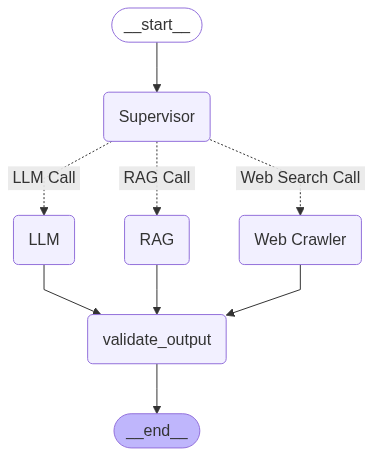

In [49]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))